
# Use case for "Modeling resilient cyber-physical processes and their composition from digital twins via Markov Decision Processes"

In this notebook, we present the implementation of the use cases for the paper "Modeling resilient cyber-physical processes and their composition from digital twins via Markov Decision Processes", submitted at BPM 2022.

## Preliminaries

### Available services

We start with the definitions of the available services and the DECLARE constraints of the task.


In [1]:
# Python imports, put at the top for simplicity
from logaut import ltl2dfa
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from pylogics.parsers import parse_ltl

from docs.notebooks.utils import render_mdp_dfa
from docs.notebooks.utils import render_service, print_policy_data, \
    print_value_function, print_q_value_function
from stochastic_service_composition.declare_utils import exactly_once, absence_2, alt_succession, alt_precedence, \
    build_declare_assumption, not_coexistence
from stochastic_service_composition.dfa_target import mdp_from_dfa
from stochastic_service_composition.momdp import compute_final_mdp
from stochastic_service_composition.services import build_service_from_transitions, Service
from mdp_dp_rl.processes.det_policy import DetPolicy
from stochastic_service_composition.dfa_target import MdpDfa



In [2]:
# default economic cost value
DEFAULT_REWARD_ECONOMIC_COST = -1.0

# default quality cost value
DEFAULT_REWARD_QUALITY_COST = -1.0

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = -2.0

# default reward to repair the device
DEFAULT_REWARD_REPAIR = -2.0

# default probability of being broken after an action
DEFAULT_BROKEN_PROB = 0.05

# default discount factor
GAMMA = 0.99

HIGH_COST = -2.0
LOW_COST = -0.5

In [3]:
# all the atomic actions for the task
BUILD_RETRIEVE_STATOR = "build_retrieve_stator"
BUILD_RETRIEVE_ROTOR = "build_retrieve_rotor"
BUILD_RETRIEVE_INVERTER = "build_retrieve_inverter"
ASSEMBLE_MOTOR = "assemble_motor"
PAINTING = "painting"
RUNNING_IN = "running_in"
ELECTRIC_TEST = "electric_test"
STATIC_TEST = "static_test"

ALL_SYMBOLS = {
    BUILD_RETRIEVE_STATOR,
    BUILD_RETRIEVE_ROTOR,
    BUILD_RETRIEVE_INVERTER,
    ASSEMBLE_MOTOR,
    PAINTING,
    RUNNING_IN,
    ELECTRIC_TEST,
    STATIC_TEST,
}

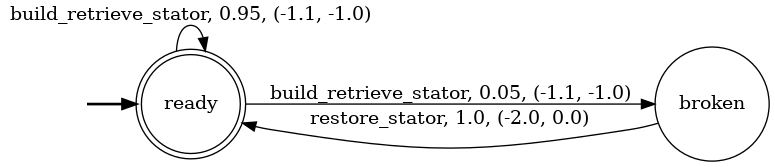

In [4]:
def stator_builder_service(
        economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST,
        quality_cost: float = DEFAULT_REWARD_QUALITY_COST,
        broken_prob: float = DEFAULT_BROKEN_PROB,
        broken_reward: float = DEFAULT_BROKEN_REWARD,
        repair_reward: float = DEFAULT_REWARD_REPAIR
) -> Service:
    """Build the stator builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob

    average_action_reward = economic_cost * (1 - broken_prob) + (economic_cost + broken_reward) * broken_prob

    transitions = {
        "ready": {
          BUILD_RETRIEVE_STATOR: ({"ready": success_prob, "broken": broken_prob}, (average_action_reward, quality_cost)),
        },
        "broken": {
            "restore_stator": ({"ready": 1.0}, (repair_reward, 0.0)),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore

service_stator_builder = stator_builder_service()
render_service(service_stator_builder)

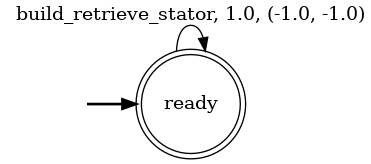

In [5]:
def stator_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the stator warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_STATOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_stator_warehouse = stator_warehouse_service()
render_service(service_stator_warehouse)

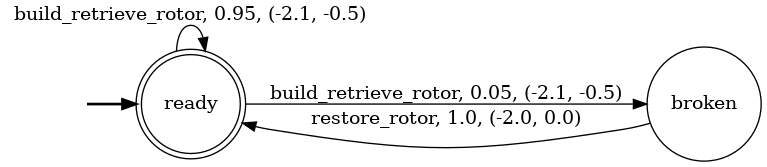

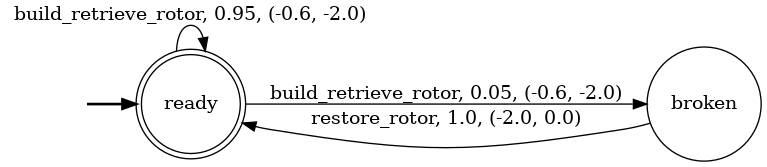

In [6]:
def rotor_builder_service(
        economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST,
        quality_cost: float = DEFAULT_REWARD_QUALITY_COST,
        broken_prob: float = DEFAULT_BROKEN_PROB,
        broken_reward: float = DEFAULT_BROKEN_REWARD,
        repair_reward: float = DEFAULT_REWARD_REPAIR
) -> Service:
    """Build the rotor builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob

    average_action_reward = economic_cost * (1 - broken_prob) + (economic_cost + broken_reward) * broken_prob

    transitions = {
        "ready": {
          BUILD_RETRIEVE_ROTOR: ({"ready": success_prob, "broken": broken_prob}, (average_action_reward, quality_cost)),
        },
        "broken": {
            "restore_rotor": ({"ready": 1.0}, (repair_reward, 0.0)),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore

# high economic cost - low quality cost
service_rotor_builder_1 = rotor_builder_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_rotor_builder_2 = rotor_builder_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_rotor_builder_1)
render_service(service_rotor_builder_2)

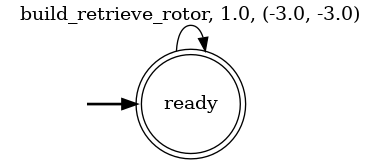

In [25]:
def rotor_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the rotor warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_ROTOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_rotor_warehouse = rotor_warehouse_service(-3.0, -3.0)
render_service(service_rotor_warehouse)

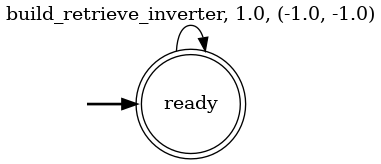

In [8]:
def inverter_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the inverter warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_INVERTER: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_inverter_warehouse = inverter_warehouse_service()
render_service(service_inverter_warehouse)

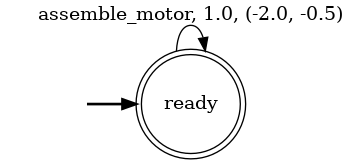

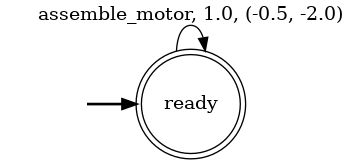

In [9]:
def assembler_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the assembler device."""
    transitions = {
        "ready": {
            ASSEMBLE_MOTOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_assembler_1 = assembler_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_assembler_2 = assembler_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)
render_service(service_assembler_1)
render_service(service_assembler_2)

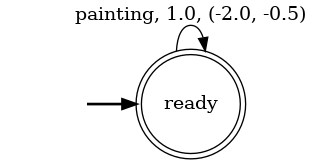

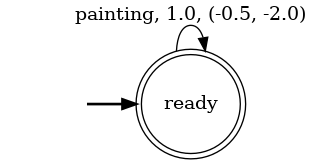

In [10]:
def painter_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the painter device."""
    transitions = {
        "ready": {
            PAINTING: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_painter_1 = painter_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_painter_2 = painter_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_painter_1)
render_service(service_painter_2)

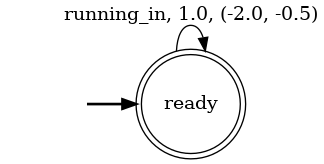

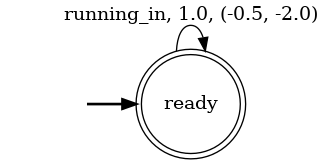

In [11]:
def smart_tester_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the smart tester device."""
    transitions = {
        "ready": {
            RUNNING_IN: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_smart_tester_1 = smart_tester_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_smart_tester_2 = smart_tester_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_smart_tester_1)
render_service(service_smart_tester_2)

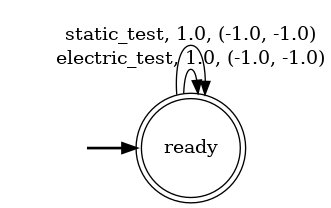

In [12]:
def mechanical_engineer_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the mechanical engineer device."""
    transitions = {
        "ready": {
            ELECTRIC_TEST: ({"ready": 1.0}, (economic_cost, quality_cost)),
            STATIC_TEST: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_mechanical_engineer = mechanical_engineer_service()
render_service(service_mechanical_engineer)

### Target specification

In this section, we list all the DECLARE constraints, transform each of them in LTLf formulas (according to the paper) and put them in conjunction in order to compute the equivalent automaton.

Then, we also show the MDP representation of the DFA.

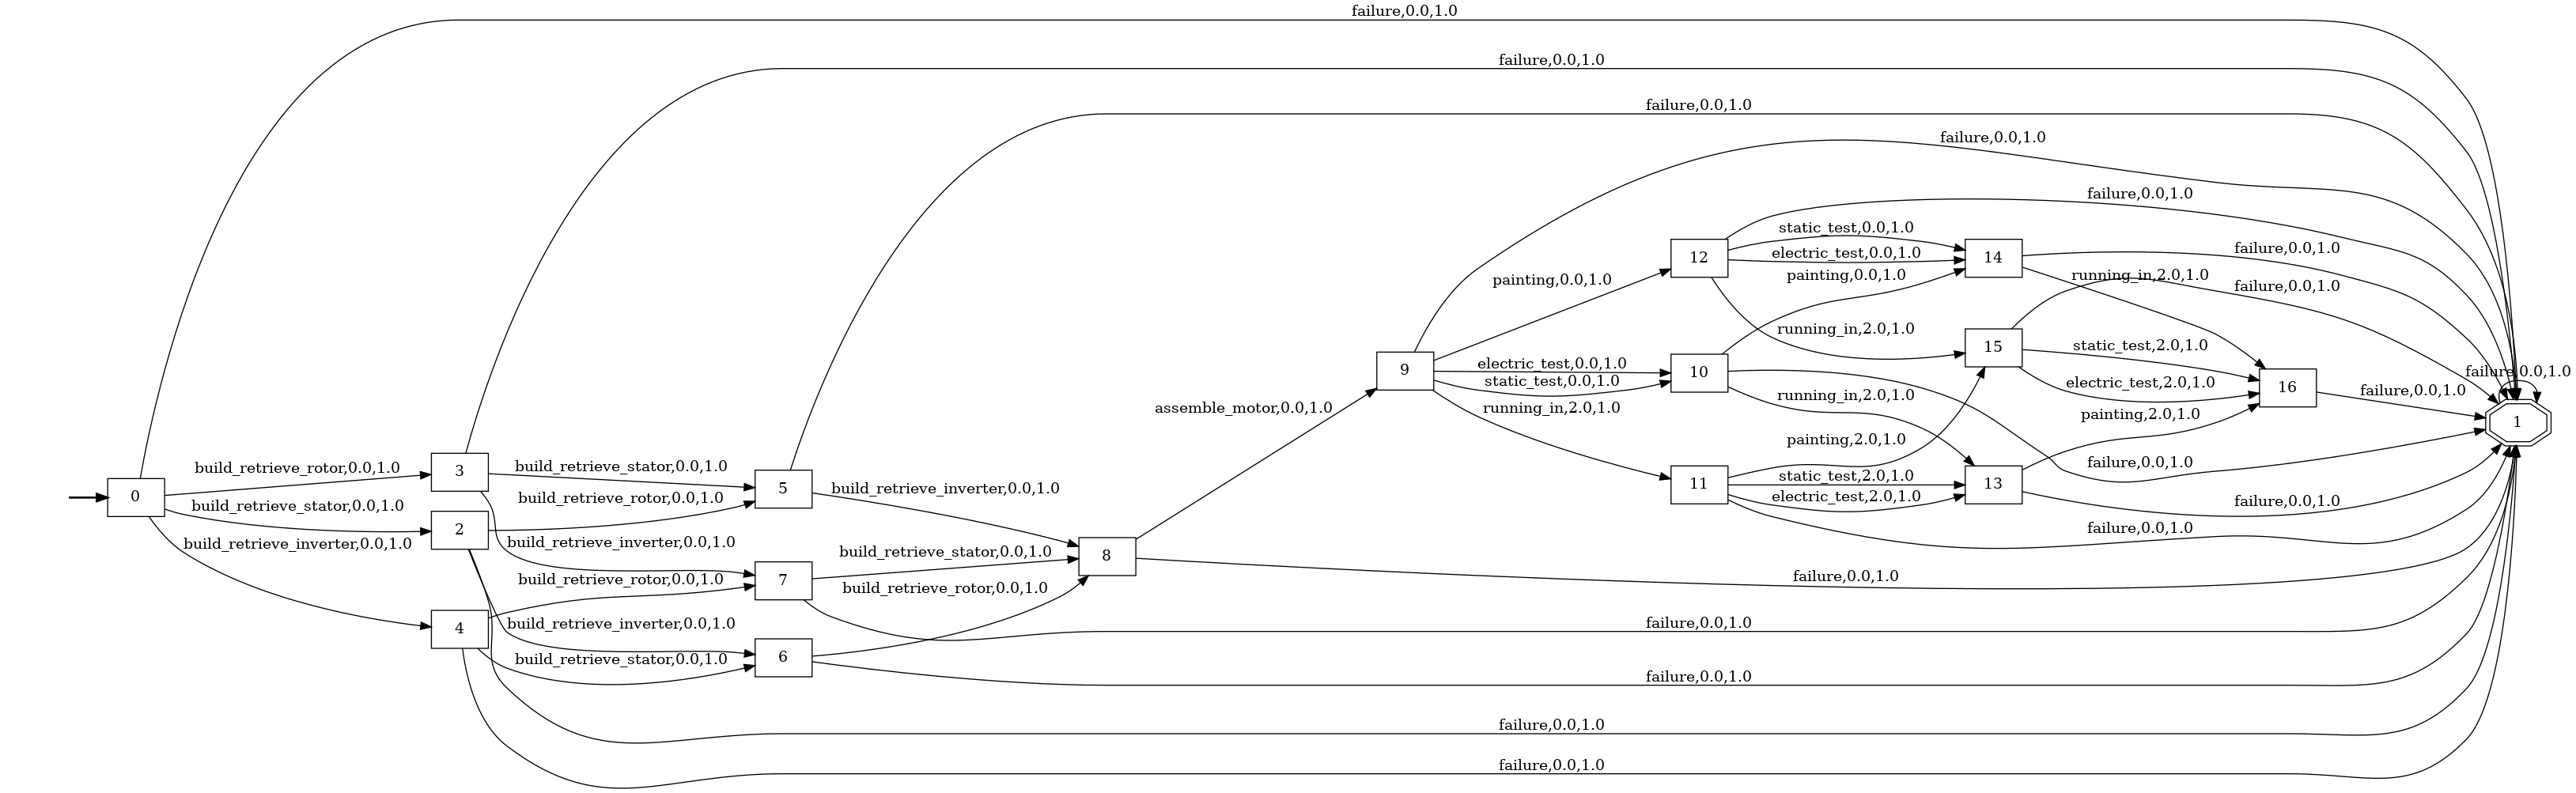

In [26]:

declare_constraints = [
    exactly_once(BUILD_RETRIEVE_STATOR),
    exactly_once(BUILD_RETRIEVE_ROTOR),
    exactly_once(BUILD_RETRIEVE_INVERTER),
    exactly_once(RUNNING_IN),
    exactly_once(ASSEMBLE_MOTOR),
    absence_2(ELECTRIC_TEST),
    absence_2(PAINTING),
    absence_2(STATIC_TEST),
    alt_succession(BUILD_RETRIEVE_STATOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_ROTOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_INVERTER, ASSEMBLE_MOTOR),
    alt_succession(ASSEMBLE_MOTOR, RUNNING_IN),
    alt_precedence(ASSEMBLE_MOTOR, PAINTING),
    alt_precedence(ASSEMBLE_MOTOR, ELECTRIC_TEST),
    alt_precedence(ASSEMBLE_MOTOR, STATIC_TEST),
    not_coexistence(ELECTRIC_TEST, STATIC_TEST),
    build_declare_assumption(ALL_SYMBOLS),
]
formula_str = " & ".join(map(lambda s: f"({s})", declare_constraints))
formula = parse_ltl(formula_str)
automaton = ltl2dfa(formula, backend="lydia")
target_mdp = mdp_from_dfa(automaton, gamma=GAMMA)
render_mdp_dfa(target_mdp)

Here we list all the services.

In [27]:
all_services = [
    service_stator_builder,        # 0
    service_stator_warehouse,      # 1
    service_rotor_builder_1,       # 2
    service_rotor_builder_2,       # 3
    service_rotor_warehouse,       # 4
    service_inverter_warehouse,    # 5
    service_assembler_1,           # 6
    service_assembler_2,           # 7
    service_painter_1,             # 8
    service_painter_2,             # 9
    service_smart_tester_1,        # 10
    service_smart_tester_2,        # 11
    service_mechanical_engineer,   # 12
]


## Economic cost > Quality cost

In the following, we compute the composition MOMDP by giving more weight to the economic cost (`2.0`) rather than the quality cost (`1.0`). The highest weight is to the target specification (`10.0`). The optimal solution will prefer using services whose economic cost of performing the main action is lower.


In [28]:
def execute_n_action_of_policy(mdp: MdpDfa, policy: DetPolicy, n, initial_state=None):
    current_state = mdp.initial_state if initial_state is None else initial_state
    for _ in range(n):
        action = policy.get_action_for_state(current_state)
        next_state_dist = final_mdp.transitions[current_state][action]
        reward = final_mdp.rewards[current_state][action]
        next_state_highest_prob = max(next_state_dist.items(), key=lambda pair: pair[1])[0]
        print(f"action={action}, reward={reward}")
        current_state = next_state_highest_prob

In [29]:
weights = [10.0, 2.0, 1.0]
final_mdp = compute_final_mdp(target_mdp, all_services, weights)
print("Number of states: ", len(final_mdp.all_states))
opn = DPAnalytic(final_mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

Number of states:  80


In [30]:
print_policy_data(opt_policy)

Policy:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('build_retrieve_stator', 1)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('build_retrieve_stator', 1)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	Action=('build_retrieve_inverter', 5)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	Action=('assemble_motor', 7)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	Action=('running_in', 11)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	Action=('running_in', 11)
State=(

In [31]:
print_value_function(value_function)

Value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-299.9999999999998
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-299.9999999999997
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	value=-241.78009979999973
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	value=-241.19201999999964
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	value=-240.59799999999973
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	value=-260.1999999999997
State=(('broken', 'ready', 'broken', 

In [32]:
execute_n_action_of_policy(final_mdp, opt_policy, 7)

action=('build_retrieve_stator', 1), reward=-3.0
action=('build_retrieve_inverter', 5), reward=-3.0
action=('build_retrieve_rotor', 3), reward=-3.2
action=('assemble_motor', 7), reward=-3.0
action=('running_in', 11), reward=17.0
action=('painting', 9), reward=17.0
action=('electric_test', 12), reward=17.0


### Discussion

In the above cell you can see the computed optimal plan:

```
action=('build_retrieve_stator', 1), reward=-3.0
action=('build_retrieve_inverter', 5), reward=-3.0
action=('build_retrieve_rotor', 3), reward=-3.2
action=('assemble_motor', 7), reward=-3.0
action=('running_in', 11), reward=17.0
action=('painting', 9), reward=17.0
action=('electric_test', 12), reward=17.0
```

You can notice that the optimal plan preferred actions from services with lower economic cost. E.g. to perform `build_retrieve_rotor`, the plan preferred using `service_rotor_builder_2` (service `3`) rather than `service_rotor_builder_1` (service `2`).
The same holds for `service_assembler_2` (service `7`), `service_painter_2` (service `9`) and `service_smart_tester_2` (service `11`).


## Quality cost > Economic cost

In the following, we compute the composition MOMDP by giving more weight to the quality cost (`5.0`) rather than the economic cost (`1.0`). The highest weight is to the target specification (`10.0`). The optimal solution will prefer using services whose quality cost of performing the main action is lower.


In [33]:
weights = [10.0, 1.0, 5.0]
final_mdp = compute_final_mdp(target_mdp, all_services, weights)
print("Number of states: ", len(final_mdp.all_states))
opn = DPAnalytic(final_mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

Number of states:  80


In [34]:
print_policy_data(opt_policy)

Policy:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('restore_stator', 0)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('restore_stator', 0)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	Action=('build_retrieve_inverter', 5)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	Action=('assemble_motor', 6)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	Action=('running_in', 10)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	Action=('running_in', 10)
State=(('broken', 're

In [35]:
print_value_function(value_function)

Value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-440.37898046688906
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-442.80705097665566
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	value=-387.8805708643616
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	value=-385.73795036804194
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	value=-385.0888387555981
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	value=-403.1501906622201
State=(('broken', 'ready', 'broken', 

In [36]:
print_q_value_function(q_value_function)

Q-value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1):
	Action=('assemble_motor', 6),	Value=-440.47519066222014
	Action=('assemble_motor', 7),	Value=-446.47519066222014
	Action=('build_retrieve_inverter', 5),	Value=-441.97519066222014
	Action=('build_retrieve_rotor', 4),	Value=-453.97519066222014
	Action=('build_retrieve_stator', 1),	Value=-441.97519066222014
	Action=('electric_test', 12),	Value=-441.97519066222014
	Action=('painting', 8),	Value=-440.47519066222014
	Action=('painting', 9),	Value=-446.47519066222014
	Action=('restore_rotor', 2),	Value=-440.3789804668891
	Action=('restore_rotor', 3),	Value=-440.3789804668891
	Action=('restore_stator', 0),	Value=-440.3789804668891
	Action=('running_in', 10),	Value=-440.47519066222014
	Action=('running_in', 11),	Value=-446.47519066222014
	Action=('static_test', 12),	Value=-441.97519066222014

State=(('broken', 'ready', 'broken', 'ready', 'ready'

In [37]:
execute_n_action_of_policy(final_mdp, opt_policy, 7)

action=('build_retrieve_rotor', 2), reward=-4.6
action=('build_retrieve_inverter', 5), reward=-6.0
action=('build_retrieve_stator', 0), reward=-6.1
action=('assemble_motor', 6), reward=-4.5
action=('running_in', 10), reward=15.5
action=('painting', 8), reward=15.5
action=('electric_test', 12), reward=14.0


### Discussion

In the above cell you can see the computed optimal plan:

```
action=('build_retrieve_rotor', 2), reward=-4.6
action=('build_retrieve_inverter', 5), reward=-6.0
action=('build_retrieve_stator', 0), reward=-6.1
action=('assemble_motor', 6), reward=-4.5
action=('running_in', 10), reward=15.5
action=('painting', 8), reward=15.5
action=('electric_test', 12), reward=14.0
```

You can notice that the optimal plan preferred actions from services with lower quality cost. E.g. to perform `build_retrieve_rotor`, the plan preferred using `service_rotor_builder_1` (service `2`) rather than `service_rotor_builder_2` (service `3`).
The same holds for `service_assembler_1` (service `6`), `service_painter_1` (service `8`) and `service_smart_tester_2` (service `10`).

